**Part 1 - Signal Manipulation**

Paulo Yoshio Kuga

Firstly, we shall import libraries that are needed in this notebook:

In [40]:
import pandas as pd
import os

import matplotlib.pyplot as plt

from scipy import signal

import scipy.fft as fourier
from scipy.signal.windows import hann

import numpy as np

import re

from scipy.stats import norm

1. *Plot each sensor data in time domain.*

We load all sensor data and plot it. A regex expression is used to obtain metadata from the name.

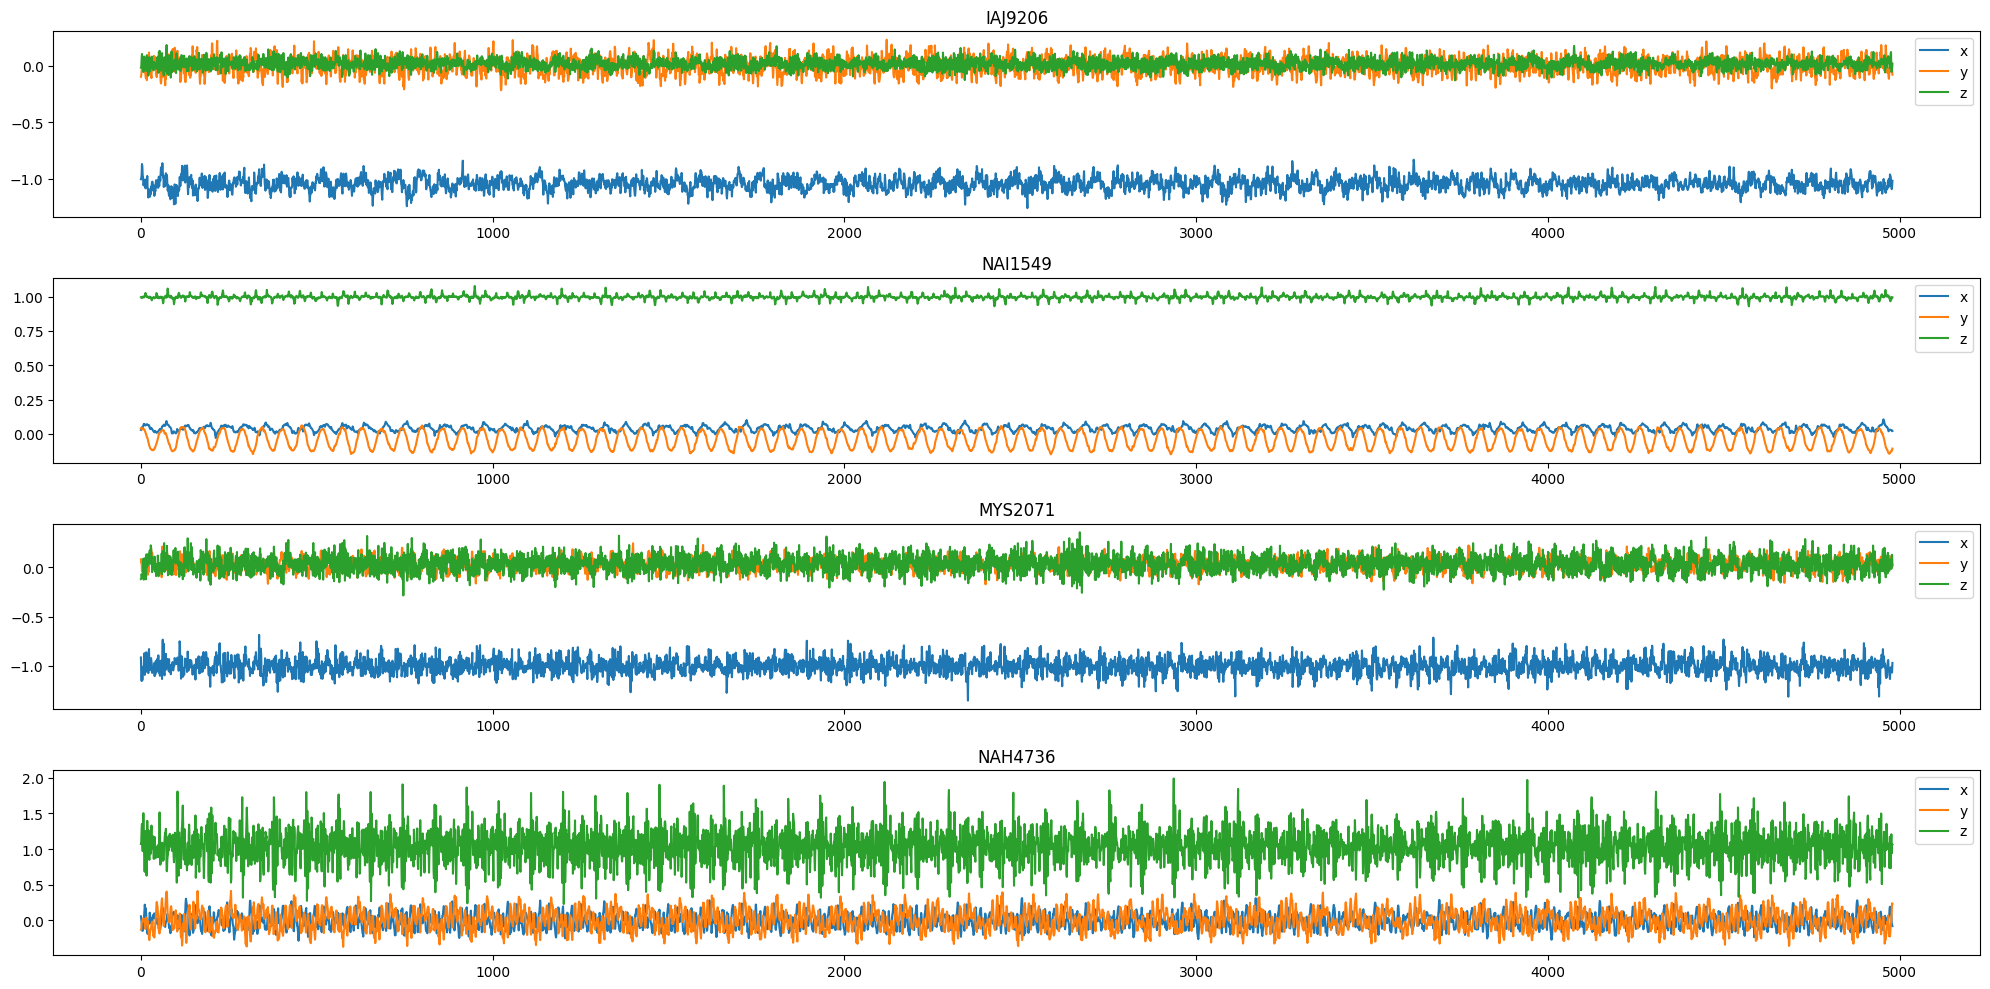

In [2]:
#path to the folder containing the csv files
path = "./part_1/"
files = os.listdir(path)

#regex pattern to separate start, interval and sensor
pat = re.compile("([0-9]*)-([0-9]*)-([A-Za-z]*[0-9]*)") 
infos = [re.findall(pat,file)[0] for file in files]

#creates a dict with all the datasets
dict_data = {file: pd.read_csv(path+file) for file in files}

#then, it is possible to plot all data
fig, axs= plt.subplots(4,1,figsize=(20,10))

for i,file in enumerate(files):
    dict_data[file].plot(ax=axs[i])
    axs[i].set_title(infos[i][2])

plt.tight_layout()

*2. Apply any processing step you find relevant given the signal visualization. Then, plot each sensor data in the frequency domain.*

It is possible to apply the FFT to the signals, centering them and applying a hanning window, intending to reduce spectral leakage. 

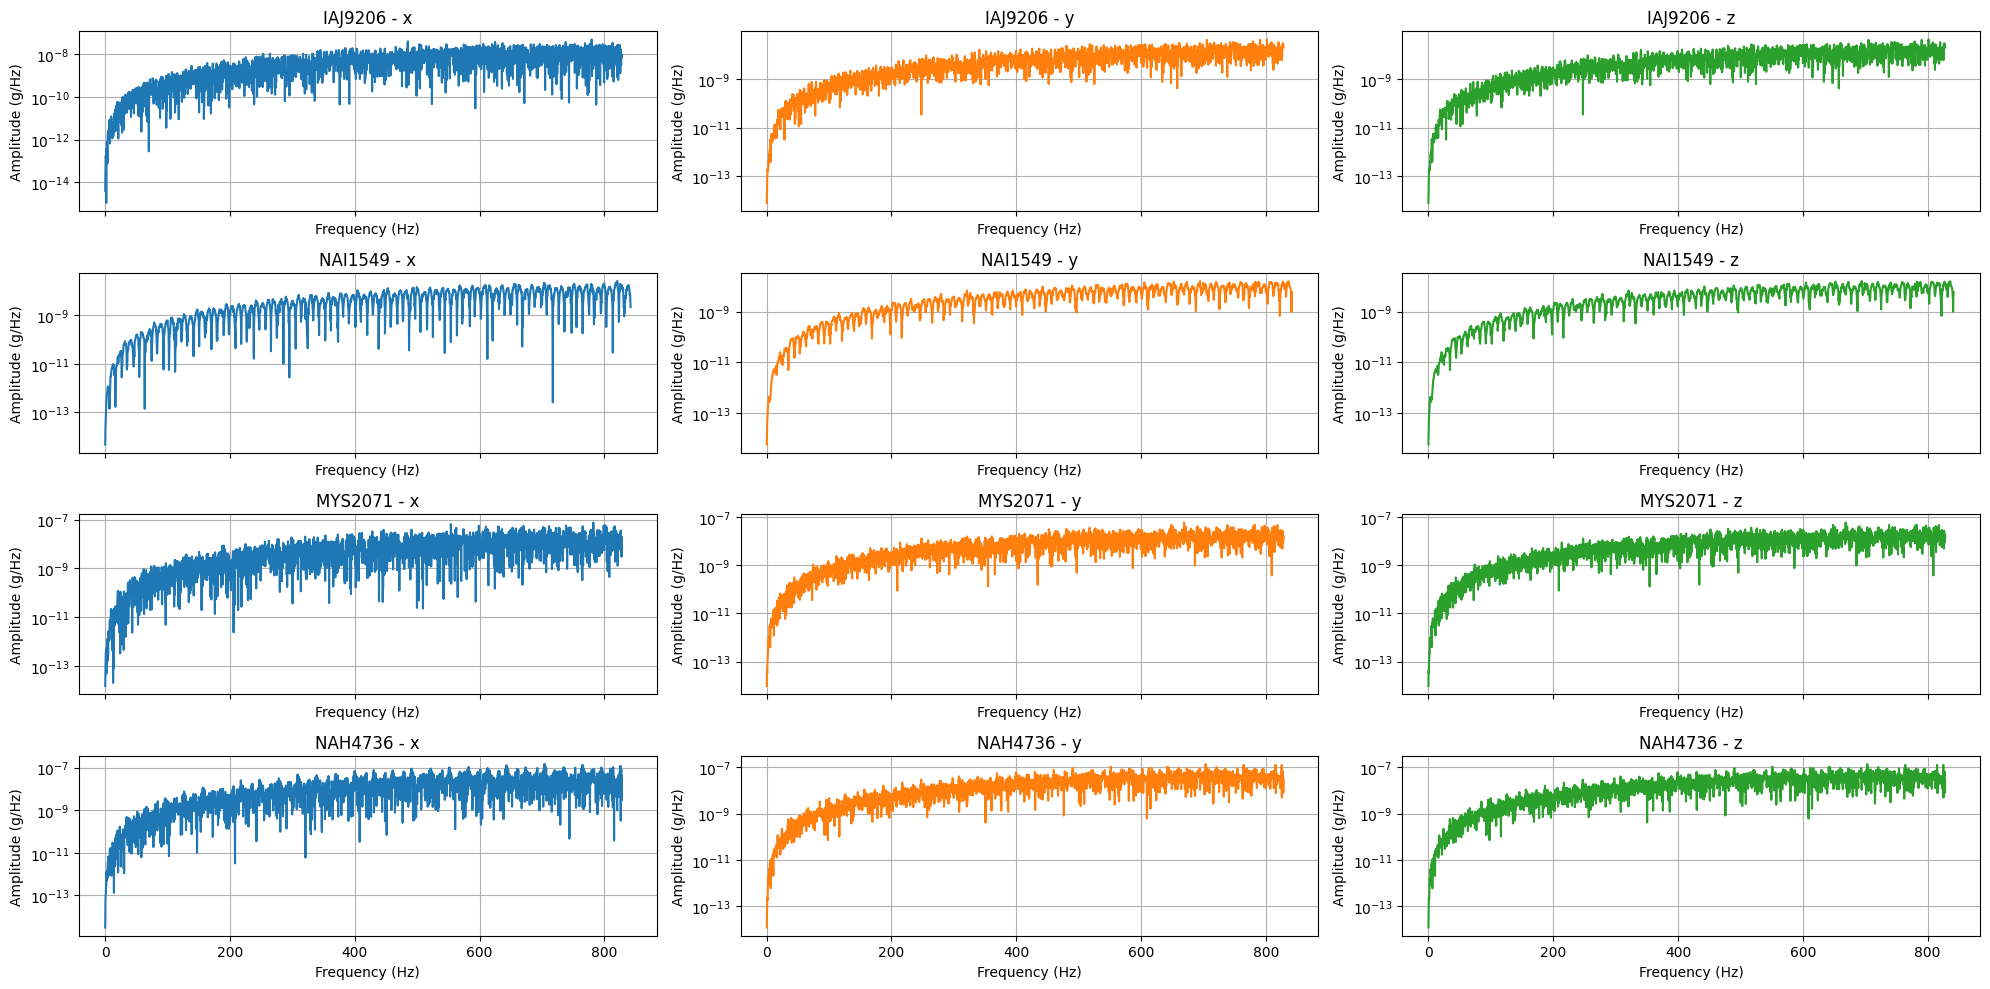

In [3]:
fig, axs= plt.subplots(4,3,figsize=(20,10),sharex=True)


for i,file in enumerate(files):

    data = dict_data[file]
    
    dataCentered = data - data.mean() #center the data with an exponential moving average (low pass filter)

    N = data.shape[0] #number of records

    T = int(infos[i][1])/1000 #s - converting the measurement period to seconds

    window = hann(N) #hanning window with N points


    xf = fourier.fft(dataCentered.mul(window,axis=0)) #FFT signal
    freq = fourier.fftfreq(N,d=T/N) #associated frequency

    absolute = np.abs(xf)
    for j in range(3):
        absolute[:,j] = absolute[:,j]/np.sum(window) *2/N

        axs[i,j].semilogy(freq[1:N//2],absolute[1:N//2,j],color='C'+str(j))
        axs[i,j].set_title(infos[i][2] + " - " + data.columns[j])
        axs[i,j].set_xlabel('Frequency (Hz)')
        axs[i,j].set_ylabel('Amplitude (g/Hz)')
        axs[i,j].grid()

plt.tight_layout()

It is possible to notice that only applying the FFT with a window it is not enough, and does not produce meaningful results. Therefore, instead of applying the simple FFT, a Welch periodogram is proposed, being an statistical mean of each frequency along the signal, which can be more meaningful. 

With relation to the standard configuration of the scipy Welch, four parameters are altered:

* Window: Flattop is a window which has less spectral leakage than hanning.

* Number of windows per second (nperseg) and Overlappping number (noverlap): these numbers were chosen intending to increase the resolution of the frequency, trying to reduce the contained noise. For the overlaps, it was used 3/4 of nperseg.

* Average: As a standard, average is the mean function. However, a more robust measurement of the center is median. 

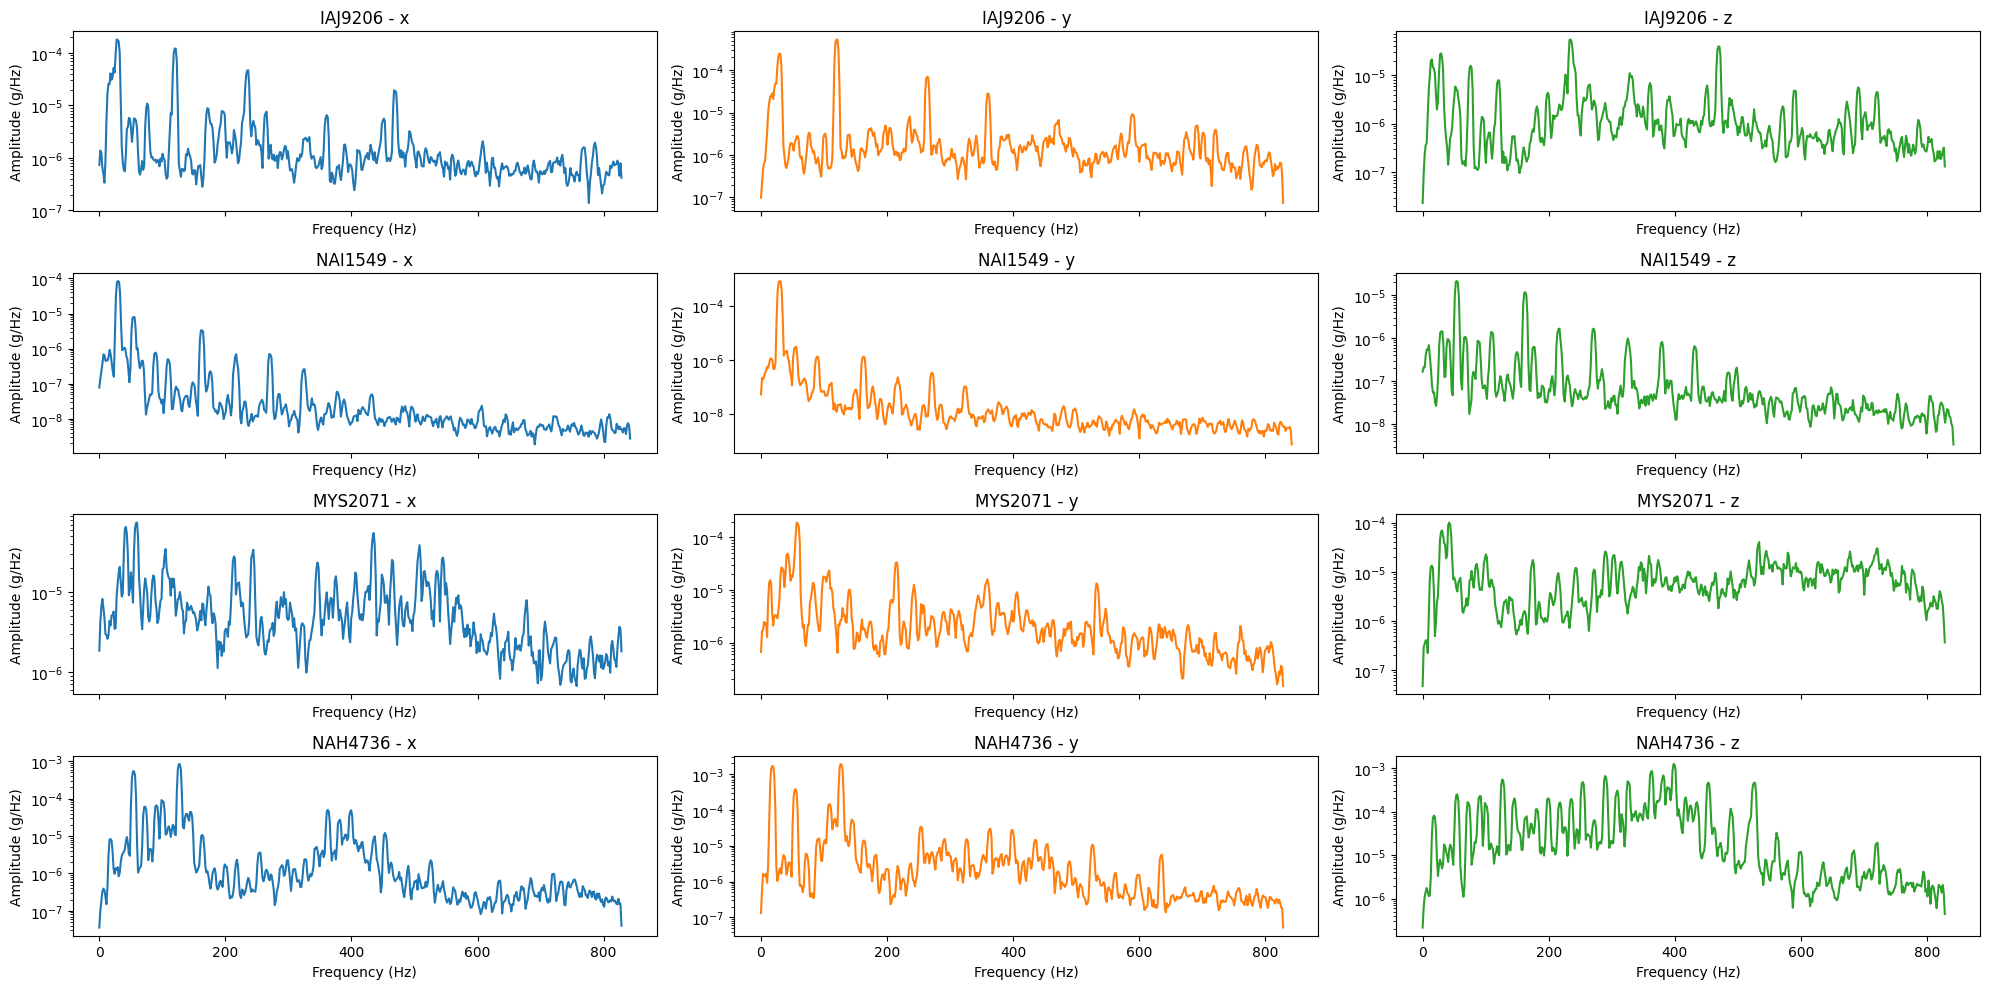

In [109]:
fig, axs= plt.subplots(4,3,figsize=(20,10),sharex=True)


nps = 1024
novp = 768

P_gg = np.zeros((len(dict_data),3,nps//2+1)) #an array to save all Welch PSD.


for i,file in enumerate(files):
    data = dict_data[file]

    dataCentered = data - data.mean() #centering data

    N = data.shape[0]

    T = int(infos[i][1])/1000 #s

    fs = N / T # sample rate

    #generate all signals Welch
    f, Pxx = signal.welch(dataCentered['x'].to_numpy(), fs=fs, window='flattop', nperseg=nps, noverlap=novp, scaling='density',average='median')
    _, Pyy = signal.welch(dataCentered['y'].to_numpy(), fs=fs, window='flattop', nperseg=nps, noverlap=novp, scaling='density',average='median')
    _, Pzz = signal.welch(dataCentered['z'].to_numpy(), fs=fs, window='flattop', nperseg=nps, noverlap=novp, scaling='density',average='median')

    P_gg[i,0,:] = Pxx
    P_gg[i,1,:] = Pyy
    P_gg[i,2,:] = Pzz

    P_g = P_gg[i,:,:]
    
    for j, ax in enumerate(axs[i]):
        ax.semilogy(f, P_g[j], color='C'+str(j))
        ax.set_title(infos[i][2] + " - " + data.columns[j])
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude (g/Hz)')
        

plt.tight_layout()

Now, with Welch, the main frequencies are easier to detect, and then, it is possible to move to item 3.

3. *Write a function that extracts the most relevant frequencies from the signal.*

If we sort the power spectrum densities obtained from Welch and get their positions in array, it is possible to obtain the main frequencies. However, accordingly to the nperseg and noverlap parameters, frequencies near the natural are going to represent the same, therefore, they need to be treated.

In [149]:
def MainFrequencies(f,Pxx,n=5,w=128):
    powerDataset = pd.Series(Pxx)
    maxPowers = powerDataset.rolling(window=w,min_periods=1,center=True).max()
    uniqueMaxPowers = maxPowers.unique()
    indexMaxFreqs = powerDataset[powerDataset.isin(uniqueMaxPowers)].sort_values(ascending=False).index

    sortedChosenFreqs = np.sort(f[indexMaxFreqs])
    forecedUnique = np.abs(sortedChosenFreqs-np.roll(sortedChosenFreqs,-1)) > 2

    return sortedChosenFreqs[forecedUnique][0:n]
    


In [150]:
MainFrequencies(f,Pxx)

array([ 53.38931512, 131.04650075, 148.84293912, 163.40366143,
       362.4001996 ])

4. When there is excessive looseness or a bearing localized failure, there can be mechanical impacts that manifest as periodic peaks in the vibration signal and excite a natural frequency. Considering the signals from all sensors and axes, find the one containing impacts that excite natural frequencies between 300 Hz and 500 Hz. Use a statistical metric to quantify the presence and extent of the impacts.

Firstly, we shall separate the natural frequencies cited.

In [22]:
condA = f >= 300
condB = f <= 500

Analysis = P_gg[:,:,condA*condB]

Then, it is possible to calculate a Z-score to measure the deviation of each axis sample, with relation to it axis. Our intent is to relate the deviation with the presence and extent of the impacts.

In [79]:
averageSpectrum = np.log10(Analysis.mean(axis=2))
Means = averageSpectrum.mean(axis=0)
Var = averageSpectrum.var(axis=0)

Z = (averageSpectrum-Means)/Var

Z

array([[ 0.18342217,  0.40944831, -0.14574168],
       [-1.65567148, -1.60754481, -1.24932609],
       [ 0.79634465,  0.50668763,  0.13452454],
       [ 0.67590466,  0.69140887,  1.26054323]])

Z-score is associated to the Standard Gaussian. This means that each Z-score value has a associated cumulated probability, which can be related to an probability of failure.

In [81]:
P = norm.cdf(Z)
P

array([[0.57276661, 0.65889465, 0.44206266],
       [0.04889418, 0.05396745, 0.10577292],
       [0.78708413, 0.693813  , 0.5535061 ],
       [0.75044941, 0.75534568, 0.89626327]])

Since we want to measure the most excited sample, we can use a logic considering the probability of failure detection in each sample. This means that if **X and Y and Z** may be, in a very simplified way, independent, then, a combined probability of failure can be obtained through axis probabilities multiplication.

In [84]:
P_p = P.prod(axis=1)
P_p

array([1.66831289e-01, 2.79102416e-04, 3.02263700e-01, 5.08045689e-01])

Since the greatest probability into combined probabilities are 50% for the 4th sample, we can assume it as the most impacted.